# Creating Transferable Clean Label Attacks in ART with Bullseye Polytope Clean Label Attacks

In [1]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from art.estimators.classification import PyTorchClassifier
from art.attacks.poisoning import BullseyePolytopeAttackPyTorch

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


      deer        dog      horse        dog


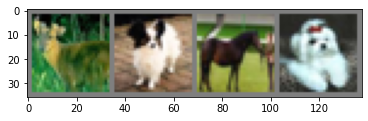

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

In [5]:
net = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10))


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
NUM_EPOCHS = 1
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 2.209
[1,  4000] loss: 1.840
[1,  6000] loss: 1.660
[1,  8000] loss: 1.544
[1, 10000] loss: 1.502
[1, 12000] loss: 1.433


In [8]:
mean = np.asarray((0.4914, 0.4822, 0.4465)).reshape((3, 1, 1))
std = np.asarray((0.2023, 0.1994, 0.2010)).reshape((3, 1, 1))

In [9]:
classifier = PyTorchClassifier(net, loss, (3, 32, 32), 10, clip_values=(0,1), preprocessing=(mean, std))

In [10]:
target = images[0].unsqueeze(0)

In [11]:
attack = BullseyePolytopeAttackPyTorch(classifier, target.numpy(), 9)

In [12]:
poison, p_labels = attack.poison(images.numpy(), labels.numpy())

     truck        dog        car      plane


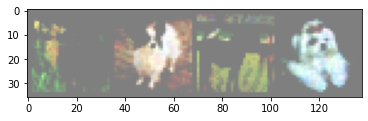

In [13]:
imshow(torchvision.utils.make_grid(torch.from_numpy(poison)))
print(' '.join('%10s' % classes[p_labels[j]] for j in range(4)))